In [4]:
#!/usr/bin/env python3
import qiskit
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    transpile
)
from qiskit.quantum_info import (
    Kraus, 
    SuperOp,
)
from qiskit_aer.noise import(
    depolarizing_error,
    phase_damping_error,
    NoiseModel,
    QuantumError,
    amplitude_damping_error,
)
# from qiskit_ibm_provider import IBMProvider
from qiskit import Aer
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import math
import sys
sys.path.append('../')
import utilities as utl
import importlib
import json
importlib.reload(utl)

SHOTS=40000
def _graph_pcsZ(qc, qreg):
    for idx in list(range(qreg.size)):
        if idx==1:
            continue
        qc.h(qreg[idx])
    qc.cz(qreg[2],qreg[0])
    qc.cx(qreg[0],qreg[1])
    qc.cx(qreg[3],qreg[0])
    qc.barrier()
    qc.id(qreg)
    qc.barrier()
    qc.cx(qreg[3],qreg[0])
    qc.cz(qreg[2],qreg[0])
    qc.h([qreg[3], qreg[2]])
    return qc
    

In [5]:
tot_pcs_ancillas=4
a_qreg=QuantumRegister(4, "a")
b_qreg=QuantumRegister(4, "b")
pcs_creg=ClassicalRegister(4,"pcs")
bsm_creg=ClassicalRegister(2, "bsm")
epr_creg=ClassicalRegister(2, "epr")
junk_creg=ClassicalRegister(4, "junk") #for removing and connecting nodes
qc=QuantumCircuit(a_qreg, b_qreg, epr_creg, bsm_creg, pcs_creg, junk_creg)
qc=_graph_pcsZ(qc, a_qreg)
qc=_graph_pcsZ(qc, b_qreg)
# # x and z measurement to connect and remove nodes, respectively.
# qc.barrier()
# qc.measure(a_qreg[2], junk_creg[0])
# qc.measure(b_qreg[2], junk_creg[1])
# qc.measure(a_qreg[4], junk_creg[2])
# qc.measure(b_qreg[4], junk_creg[3])

# PCS measurements.
qc.barrier()
qc.measure(a_qreg[2], pcs_creg[0])
qc.measure(b_qreg[2], pcs_creg[1])
qc.measure(a_qreg[3], pcs_creg[2])
qc.measure(b_qreg[3], pcs_creg[3])
# Convert 2 qubit graph states to bell States.
# qc.h(a_qreg[0])
# qc.h(b_qreg[0])

#BSM measurement.
qc.barrier()
qc.cx(a_qreg[1], b_qreg[1])
qc.h(a_qreg[1])
qc.measure(a_qreg[1], bsm_creg[0])
qc.measure(b_qreg[1], bsm_creg[1])
utl._add_fixing_gates(qc, a_qreg, bsm_creg, 0)
qc.draw(fold=-1)

┌───┐        ┌───┐ ░ ┌───┐ ░ ┌───┐                ░       ░                 ░              ░               ░ ┌────────── ┌──────────── ┌───┐┌──────────── ┌───┐┌──────────── ┌───┐┌───┐ ───────┐ 
   a_0: ┤ H ├─■───■──┤ X ├─░─┤ I ├─░─┤ X ├──■─────────────░───────░─────────────────░──────────────░───────────────░─┤ Switch-0  ┤ Case-0 (1)  ┤ Z ├┤ Case-0 (2)  ┤ X ├┤ Case-0 (3)  ┤ X ├┤ Z ├  End-0 ├─
        └───┘ │ ┌─┴─┐└─┬─┘ ░ ├───┤ ░ └─┬─┘  │             ░       ░                 ░              ░      ┌───┐┌─┐ ░ └────╥───── └──────────── └───┘└──────────── └───┘└──────────── └───┘└───┘ ───────┘ 
   a_1: ──────┼─┤ X ├──┼───░─┤ I ├─░───┼────┼─────────────░───────░─────────────────░──────────────░───■──┤ H ├┤M├─░──────╫──────────────────────────────────────────────────────────────────────────────
        ┌───┐ │ └───┘  │   ░ ├───┤ ░   │    │  ┌───┐      ░       ░                 ░ ┌─┐          ░   │  └───┘└╥┘ ░      ║                                                                              
   a_2: ┤ H ├─■────────┼───░─┤ I ├─░───┼────■──┤ H ├──────░───────░─────────────────░─┤M├──────────░───┼────────╫──░──────╫──────────────────────────────────────────────────────────────────────────────
        ├───┤          │   ░ ├───┤ ░   │  ┌───┐└───┘      ░       ░                 ░ └╥┘   ┌─┐    ░   │        ║  ░      ║                                                                              
   a_3: ┤ H ├──────────■───░─┤ I ├─░───■──┤ H ├───────────░───────░─────────────────░──╫────┤M├────░───┼────────╫──░──────╫──────────────────────────────────────────────────────────────────────────────
        └───┘              ░ └───┘ ░ ┌───┐└───┘     ┌───┐ ░ ┌───┐ ░ ┌───┐           ░  ║    └╥┘    ░   │        ║  ░      ║                                                                              
   b_0: ───────────────────░───────░─┤ H ├──■────■──┤ X ├─░─┤ I ├─░─┤ X ├──■────────░──╫─────╫─────░───┼────────╫──░──────╫──────────────────────────────────────────────────────────────────────────────
                           ░       ░ └───┘  │  ┌─┴─┐└─┬─┘ ░ ├───┤ ░ └─┬─┘  │        ░  ║     ║     ░ ┌─┴─┐ ┌─┐  ║  ░      ║                                                                              
   b_1: ───────────────────░───────░────────┼──┤ X ├──┼───░─┤ I ├─░───┼────┼────────░──╫─────╫─────░─┤ X ├─┤M├──╫──░──────╫──────────────────────────────────────────────────────────────────────────────
                           ░       ░ ┌───┐  │  └───┘  │   ░ ├───┤ ░   │    │  ┌───┐ ░  ║ ┌─┐ ║     ░ └───┘ └╥┘  ║  ░      ║                                                                              
   b_2: ───────────────────░───────░─┤ H ├──■─────────┼───░─┤ I ├─░───┼────■──┤ H ├─░──╫─┤M├─╫─────░────────╫───╫──░──────╫──────────────────────────────────────────────────────────────────────────────
                           ░       ░ ├───┤            │   ░ ├───┤ ░   │  ┌───┐└───┘ ░  ║ └╥┘ ║ ┌─┐ ░        ║   ║  ░      ║                                                                              
   b_3: ───────────────────░───────░─┤ H ├────────────■───░─┤ I ├─░───■──┤ H ├──────░──╫──╫──╫─┤M├─░────────╫───╫──░──────╫──────────────────────────────────────────────────────────────────────────────
                           ░       ░ └───┘                ░ └───┘ ░      └───┘      ░  ║  ║  ║ └╥┘ ░        ║   ║  ░      ║                                                                              
 epr: 2/═══════════════════════════════════════════════════════════════════════════════╬══╬══╬══╬═══════════╬═══╬═════════╬══════════════════════════════════════════════════════════════════════════════
                                                                                       ║  ║  ║  ║           ║   ║      ┌──╨──┐                                                                           
 bsm: 2/═══════════════════════════════════════════════════════════════════════════════╬══╬══╬══╬═══════════╩═══╩══════╡ 0x3 ╞════════════════════════════════════════════

In [6]:
pcs_all_fidelities=[]
pcs_post_select_rates=[]
errors=np.linspace(0.0, stop=0.5, num=11, endpoint=True)
error_gate1=0.001
for error in errors:
        noise_model=utl.get_noise_model(error_gate1)
        print(f"depolarizing error: {error}")
        depol1=depolarizing_error(error, 1)
        noise_model.add_all_qubit_quantum_error(depol1, ["id"])
        print(noise_model)

        backend=AerSimulator(noise_model=noise_model)
        pcs_ancillas_pos=1 # the position of the classical registers that contain the pcs measurements.
        result_xx=utl.meas_xx(qc, [a_qreg[0], b_qreg[0]], epr_creg, backend, SHOTS)
        result_yy=utl.meas_yy(qc, [a_qreg[0], b_qreg[0]], epr_creg, backend, SHOTS)
        result_zz=utl.meas_zz(qc, [a_qreg[0], b_qreg[0]], epr_creg, backend, SHOTS)

        xx_counts=utl.post_select(result_xx.get_counts(), tot_pcs_ancillas, pcs_ancillas_pos)
        yy_counts=utl.post_select(result_yy.get_counts(), tot_pcs_ancillas, pcs_ancillas_pos)
        zz_counts=utl.post_select(result_zz.get_counts(), tot_pcs_ancillas, pcs_ancillas_pos)
        pcs_post_select_rates.append(min([sum(xx_counts.values()),sum(yy_counts.values()),sum(zz_counts.values())])/SHOTS)
        epr_idx=-1 #the position of the classical registers that contain measurements of the 
                #epr pair.
        expect_xx=utl.expect_of_vals(utl.to_percent(utl.collect_meas(xx_counts, epr_idx)))
        expect_yy=utl.expect_of_vals(utl.to_percent(utl.collect_meas(yy_counts, epr_idx)))
        expect_zz=utl.expect_of_vals(utl.to_percent(utl.collect_meas(zz_counts, epr_idx)))
        pcs_fidelity=utl.fidelity_phip(expect_xx, expect_yy, expect_zz)
        print(pcs_fidelity)
        pcs_all_fidelities.append(pcs_fidelity)

depolarizing error: 0.0
NoiseModel:
  Basis gates: ['ccx', 'cx', 'cz', 'h', 'id', 'rz', 'sx', 'x', 'y', 'z']
  Instructions with noise: ['cz', 'rz', 'measure', 'ccx', 'cx', 'y', 'h', 'x', 'z']
  All-qubits errors: ['cx', 'cz', 'ccx', 'h', 'x', 'y', 'z', 'rz', 'measure']
xx circ: 
        ┌───┐        ┌───┐ ░ ┌───┐ ░ ┌───┐                ░       ░           »
   a_0: ┤ H ├─■───■──┤ X ├─░─┤ I ├─░─┤ X ├──■─────────────░───────░───────────»
        └───┘ │ ┌─┴─┐└─┬─┘ ░ ├───┤ ░ └─┬─┘  │             ░       ░           »
   a_1: ──────┼─┤ X ├──┼───░─┤ I ├─░───┼────┼─────────────░───────░───────────»
        ┌───┐ │ └───┘  │   ░ ├───┤ ░   │    │  ┌───┐      ░       ░           »
   a_2: ┤ H ├─■────────┼───░─┤ I ├─░───┼────■──┤ H ├──────░───────░───────────»
        ├───┤          │   ░ ├───┤ ░   │  ┌───┐└───┘      ░       ░           »
   a_3: ┤ H ├──────────■───░─┤ I ├─░───■──┤ H ├───────────░───────░───────────»
        └───┘              ░ └───┘ ░ ┌───┐└───┘     ┌───┐ ░ ┌───┐ ░ ┌───┐     »

0.3134038384137179
[0.9376, 0.764075, 0.62825, 0.513125, 0.419825, 0.3395, 0.2791, 0.2323, 0.1884, 0.160125, 0.134125]


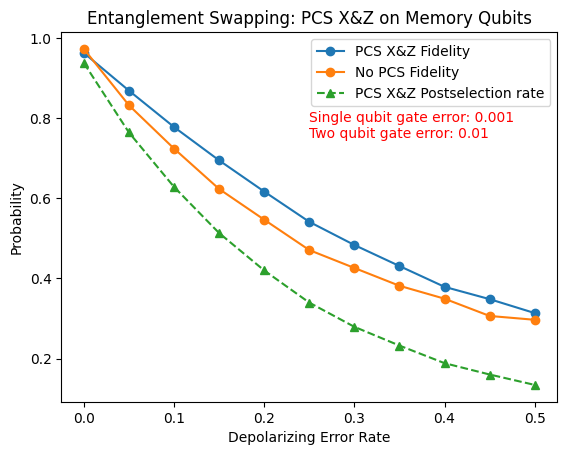

In [8]:
print(pcs_fidelity)
print(pcs_post_select_rates)
# reps=2
with open(f"json\\pcsXZ_mem_unbiased.json", "w") as fxz:
        json.dump({"errors": errors.tolist(), "fidelities": pcs_all_fidelities, "postselectRates": pcs_post_select_rates}, fxz)
with open("json\\raw_unbiased.json") as fRaw:
        dataRaw=json.load(fRaw)
nopcs_all_fidelities=dataRaw["fidelities"]
plt.plot(errors, pcs_all_fidelities, label="PCS X&Z Fidelity", marker='o')
plt.plot(errors, nopcs_all_fidelities, label="No PCS Fidelity", marker='o')
plt.plot(errors, pcs_post_select_rates, label="PCS X&Z Postselection rate",  marker='^', linestyle="--")
plt.ylabel('Probability')
plt.xlabel(f"Depolarizing Error Rate")
plt.text(0.25, .75, f"Single qubit gate error: {error_gate1}\nTwo qubit gate error: {round(error_gate1*10, 4)}", color = "red")
plt.title(f"Entanglement Swapping: PCS X&Z on Memory Qubits")
plt.legend()
plt.savefig(f"images\\pcsXZ_memory_equal_depol.png")
plt.show()